In [1]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: ncdf4
Loading required package: R.matlab
Warning message:
"package 'R.matlab' was built under R version 3.4.3"R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Loading required package: openxlsx
Warning message:
"package 'openxlsx' was built under R version 3.4.3"Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.4.3"Loading required package: geosphere
Warning message:
"package 'geosphere' was built under R version 3.4.3"Loading required package: readxl
Loading required package: data.table
Warning message:
"package 'data.table' was built under R version 3.4.3"Loading required package: rworldmap
Warning message:
"package 'rworldmap' was built under R version 3.4.3"Loading required package: sp
Warning message:
"

# FRRF Analysis Module

1. Load and extract data

2. Fit Model and extract model parameters

3. Compare Chl

In [2]:
input.dir = 'Raw Data/FRRF/'

frrf.files = list.files(input.dir, pattern = '*.csv')

length(frrf.files)

[1] 929

In [3]:
load.frrf = function(input.dir, file.name, verbose = TRUE) {
    col.names = c('Saq', 'E', 'Start', 's', 'Chl', 'ADC', 'rP.obs', 'rP.fit', 'JPII', 'JVPII', 'Fo', 'Fm', 'Fv.Fm',
                  'C', 'p', 'RSigma', 'Sigma', 'CSQ', 'TauES', 'NPQ', 'NSV', 'QR', 'Qo', 'Qm', 'Qo.SE', 'Qm.SE',
                  'Q.SE', 'Q.SE.ratio', 'Qo.points', 'Qo.slope', 'Qo.int', 'Qm.points', 'Qm.slope', 'Qm.int')
    
    file = paste0(input.dir, file.name)
    
    year = substr(file.name, 1, 4)
    month = substr(file.name, 5, 6)
    day = substr(file.name, 7, 8)
    hour = substr(file.name, 10, 11)
    minute = substr(file.name, 12, 13)
    second = substr(file.name, 14, 15)
    
    ## Make this robust (& give us useful error message if you cannot load the file)
    tryCatch({
        datetime = as.POSIXct(paste0(year, '-', month, '-', day, ' ', hour, ':', minute, ':', second))

        if (verbose) {
            print(paste0('Loading file: ', file.name,' (', datetime, ')'))
        }

        data.a = fread(file, sep = ',', skip = 29, nrows = 21, showProgress = FALSE)
        data.a = data.a[,-c(1, 23, 31)]
        colnames(data.a) = col.names
        data.a = as.data.frame(data.a)

        data.b = fread(file, sep = ',', skip = 53, nrows = 21, showProgress = FALSE)
        data.b = data.b[,-c(1, 23, 31)]
        colnames(data.b) = col.names
        data.b = as.data.frame(data.b)

        data.c = fread(file, sep = ',', skip = 77, nrows = 21, showProgress = FALSE)
        data.c = data.c[,-c(1, 23, 31)]
        colnames(data.c) = col.names
        data.c = as.data.frame(data.c)

        data.d = fread(file, sep = ',', skip = 101, nrows = 21, showProgress = FALSE)
        data.d = data.d[,-c(1, 23, 31)]
        colnames(data.d) = col.names
        data.d = as.data.frame(data.d)

        data.s = fread(file, sep = ',', skip = 1, nrows = 6)
        data.s = as.data.frame(data.s)

        if (verbose) {
            print('... Data Loaded.')
        }

        #list(Time = datetime, A = data.a, B = data.b, C = data.c, D = data.d, S = data.s)
        list(Time = datetime, A = data.a, B = data.b, C = data.c, D = data.d, S = data.s)
        
    }, error = function(e) {
        print('~~~~~~~~~~~~~~~~~')
        print(paste0('!!  Error loading file: ', file.name))
        print('~~~~~~~~~~~~~~~~~')
        return(NULL)
    })
}

In [5]:
data = load.frrf(input.dir, frrf.files[1])

data$A$E

[1] "Loading file: 20170531-135236.csv (2017-05-31 13:52:36)"
[1] "... Data Loaded."


[1]    0   20   42   69  100  135  177  226  282  348  424  513  616  736  876
[16] 1038 1227 1447 1703 2000    0

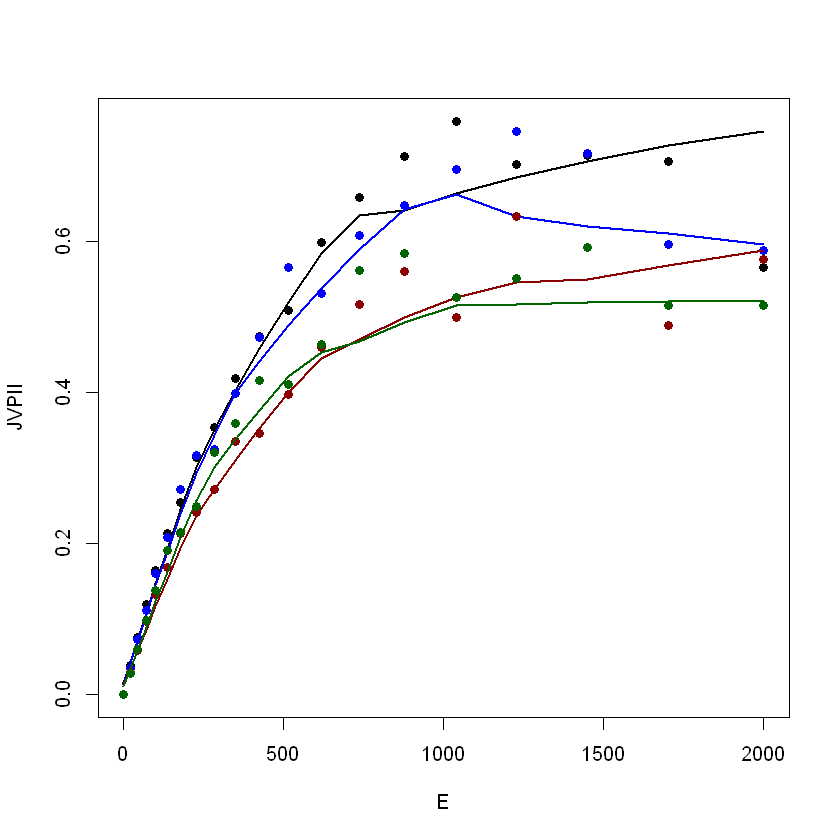

In [6]:
plot(data$A$E, data$A$JVPII, pch = 16, ylab='JVPII', xlab='E')
lines(lowess(data$A$E, data$A$JVPII, f = 0.6), col='black', lwd=2)

points(data$B$E, data$B$JVPII, pch = 16, col='blue')
lines(lowess(data$B$E, data$B$JVPII, f = 0.6), col='blue', lwd=2)

points(data$C$E, data$C$JVPII, pch = 16, col='dark red')
lines(lowess(data$C$E, data$C$JVPII, f = 0.6), col='dark red', lwd=2)

points(data$D$E, data$D$JVPII, pch = 16, col='dark green')
lines(lowess(data$D$E, data$D$JVPII, f = 0.6), col='dark green', lwd=2)

In [7]:
## Models
model = function(A, I, alpha, beta) {
    A * (1 - exp(-alpha * I / A)) * exp(-beta * I / A)  ## Platt 1980
}

## Excel Models
model.1 = function(phi, P, R, I) {
    (phi * I * P) / (phi * I + P) - R
}

model.3 = function(phi, P, R, I) {
    (phi * I * P) / sqrt(phi^2 * I^2 + P^2) - R
}

model.4 = function(phi, P, R, I) {
    P * tanh(phi * I / P) - R
}

model.8 = function(phi, P, R, I) {
    P * (1 - exp(-phi * I / P)) - R
}

In [8]:
fit.model = function(coef, A.true, I) {
    sum(abs(A.true - model(coef[1], I, coef[2], coef[3])))
}


get.fit.JVPII = function(data, N = 10) {
    
    fit = optim(par = list(A = 550, alpha = 0.4, beta = 0.01), upper = c(1000, 10, 10),
             fn = fit.model, A.true = data$JVPII, I = data$E, method = 'L-BFGS-B')
    
    fits.boot = data.frame(A = 0, alpha = 0, beta = 0)

    for (i in 1:N) {
        l = sample(1:nrow(data), replace = TRUE, size = nrow(data))
        
        fits = optim(par = list(A = 550, alpha = 0.2, beta = 0.2),
                 fn = fit.model, A.true = data$JVPII[l], I = data$E[l])
        
        fits.boot = rbind(fits.boot, c(fits$par[1], fits$par[2], fits$par[3]))
    }
    
    fits.boot = fits.boot[-1,]
    fits.boot = fits.boot[fits.boot$A < 800 & fits.boot$A > 200 &
                          fits.boot$alpha < 10 & fits.boot$alpha > 0 &
                          fits.boot$beta < 10 & fits.boot$beta > 0,]
    
    fit$par[1] = quantile(fits.boot$A, na.rm = TRUE, probs = 0.5)
    fit$par[2] = quantile(fits.boot$alpha, na.rm = TRUE, probs = 0.5)
    fit$par[3] = quantile(fits.boot$beta, na.rm = TRUE, probs = 0.5)
    
    list(fit = fit$par, bootstrap = fits.boot, data = data)
}

In [9]:
add.boot.pred = function(fit, col = '#00000040') {
    polygon(x = c(fit$pred$x, rev(fit$pred$x)), y = c(fit$pred$upper, rev(fit$pred$lower)), col=col, border = FALSE)
    lines(x = fit$pred$x, y = fit$pred$y, lty = 2)
}

make.prediction = function(fit, level = 0.95) {
    x = seq(1, 5e3, 25)
    y.lower = c()
    y.upper = c()
    yy = c()
    
    for (i in 1:length(x)) {
        temp = apply(fit$bootstrap, 1, function(xx) {
            model(A = xx[1], I = x[i], alpha = xx[2], beta = xx[3])
        })
        
        y.lower = c(y.lower, quantile(x = temp, probs = (1-level)/2, na.rm = TRUE))
        y.upper = c(y.upper, quantile(x = temp, probs = 1 - (1-level)/2, na.rm = TRUE))
        yy = c(yy, quantile(x = temp, probs = 0.5, na.rm = TRUE))
    }
    
    fit$pred = data.frame(x = x, y = yy, upper = y.upper, lower = y.lower)
    fit$pred.level = level
    
    fit
}

plot.fit.JVPII = function(fit) {
    plot(fit$data$E, fit$data$JVPII, ylab='JVPII', xlab='E')
    add.boot.pred(fit)
}

add.best.model = function(fit) {
    score = c()
    for (i in 1:nrow(fit$bootstrap)) {
        temp.y = model(A = fit$bootstrap$A[i], I = fit$pred$x, alpha = fit$bootstrap$alpha[i], beta =  fit$bootstrap$beta[i])
        score = c(score, sum((temp.y - fit$pred$y)^2))
    }
    l = which.min(score)
    fit$fit.best = list(A = fit$bootstrap$A[l], alpha = fit$bootstrap$alpha[l],
                        beta =  fit$bootstrap$beta[l], score = min(score))
    fit
}

In [13]:
data = load.frrf(input.dir, frrf.files[1])

fit = get.fit.JVPII(data$A, N = 4000)
fit = make.prediction(fit, level = 0.95)
fit = add.best.model(fit)
fit$data = data

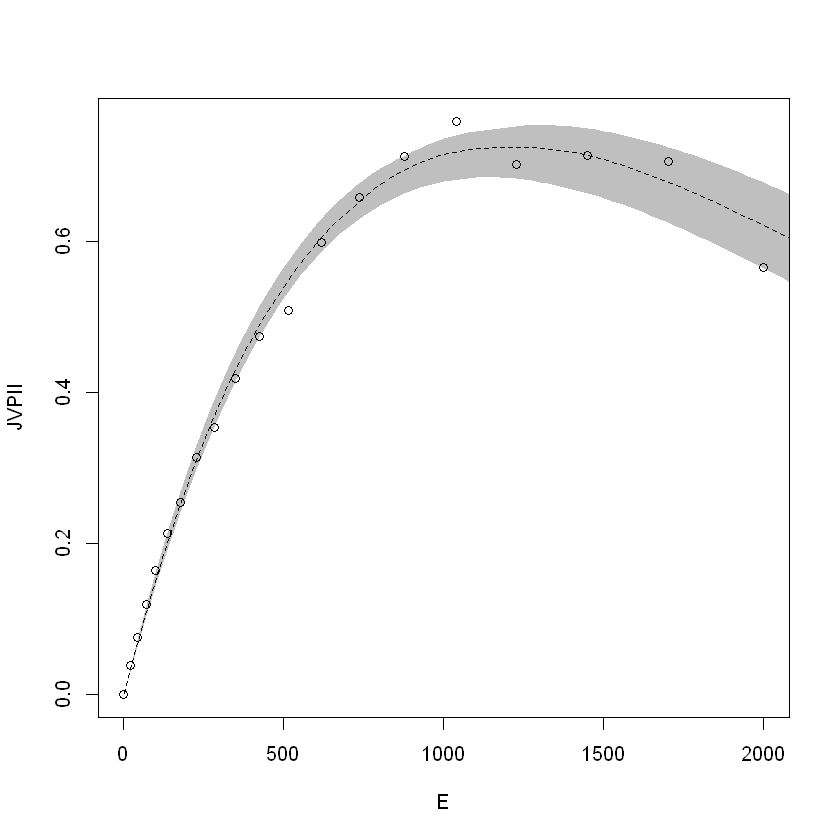

In [29]:
plot.fit.JVPII(fit)

In [27]:
fit = add.best.model(fit)

In [42]:
for (i in frrf.files) {
    ##
    try({data = load.frrf(input.dir, i)

    fit = get.fit.JVPII(data$A, N = 4000)
    fit = make.prediction(fit, level = 0.95)
    fit = add.best.model(fit)
    fit$data = data
    save(fit, file = paste0('RStates/FRRF/', as.numeric(data$Time), '.rdata'))})
}


[1] "Loading file: 20170531-135236.csv (2017-05-31 13:52:36)"
[1] "... Data Loaded."
[1] "Loading file: 20170531-144202.csv (2017-05-31 14:42:02)"
[1] "... Data Loaded."
[1] "Loading file: 20170601-184009.csv (2017-06-01 18:40:09)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 49 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 70 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170601-185148.csv (2017-06-01 18:51:48)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170601-185148.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170601-191807.csv (2017-06-01 19:18:07)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170601-194445.csv (2017-06-01 19:44:45)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 50 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 72 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 94 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170601-201004.csv (2017-06-01 20:10:04)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 48 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 68 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170601-203624.csv (2017-06-01 20:36:24)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170601-210303.csv (2017-06-01 21:03:03)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 50 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 72 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 94 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170601-212720.csv (2017-06-01 21:27:20)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 48 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 68 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170601-215356.csv (2017-06-01 21:53:56)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170601-223741.csv (2017-06-01 22:37:41)"
[1] "... Data Loaded."
[1] "Loading file: 20170601-230857.csv (2017-06-01 23:08:57)"
[1] "... Data Loaded."
[1] "Loading file: 20170601-234014.csv (2017-06-01 23:40:14)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-001130.csv (2017-06-02 00:11:30)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-004246.csv (2017-06-02 00:42:46)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-011402.csv (2017-06-02 01:14:02)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-014518.csv (2017-06-02 01:45:18)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-021635.csv (2017-06-02 02:16:35)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-024751.csv (2017-06-02 02:47:51)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-031907.csv (2017-06-02 03:19:07)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-035023.csv (2017-06-02 03:50:23)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-041644.csv (20

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170602-044814.csv (2017-06-02 04:48:14)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-051930.csv (2017-06-02 05:19:30)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-055046.csv (2017-06-02 05:50:46)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-062202.csv (2017-06-02 06:22:02)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-065319.csv (2017-06-02 06:53:19)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-072435.csv (2017-06-02 07:24:35)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-075551.csv (2017-06-02 07:55:51)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-082707.csv (2017-06-02 08:27:07)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-085823.csv (2017-06-02 08:58:23)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-093046.csv (2017-06-02 09:30:46)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-100202.csv (2017-06-02 10:02:02)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-103318.csv (20

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170602-120302.csv (2017-06-02 12:03:02)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-123419.csv (2017-06-02 12:34:19)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-130658.csv (2017-06-02 13:06:58)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-133814.csv (2017-06-02 13:38:14)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-141408.csv (2017-06-02 14:14:08)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-144631.csv (2017-06-02 14:46:31)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-152050.csv (2017-06-02 15:20:50)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-155206.csv (2017-06-02 15:52:06)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-162605.csv (2017-06-02 16:26:05)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-165158.csv (2017-06-02 16:51:58)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170602-172328.csv (2017-06-02 17:23:28)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-175444.csv (2017-06-02 17:54:44)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-182600.csv (2017-06-02 18:26:00)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-185717.csv (2017-06-02 18:57:17)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-193527.csv (2017-06-02 19:35:27)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-200714.csv (2017-06-02 20:07:14)"
[1] "... Data Loaded."
[1] "Loading file: 20170602-203124.csv (2017-06-02 20:31:24)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 45 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 79 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170602-203124.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170602-205752.csv (2017-06-02 20:57:52)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170602-212215.csv (2017-06-02 21:22:15)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 48 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 68 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170602-214855.csv (2017-06-02 21:48:55)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170602-221628.csv (2017-06-02 22:16:28)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170602-224337.csv (2017-06-02 22:43:37)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 49 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 70 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170602-225818.csv (2017-06-02 22:58:18)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170602-225818.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170602-232243.csv (2017-06-02 23:22:43)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 48 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 68 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170602-234907.csv (2017-06-02 23:49:07)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170603-001643.csv (2017-06-03 00:16:43)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 50 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 72 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 94 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170603-004828.csv (2017-06-03 00:48:28)"
[1] "... Data Loaded."
[1] "Loading file: 20170603-015946.csv (2017-06-03 01:59:46)"
[1] "... Data Loaded."
[1] "Loading file: 20170603-022915.csv (2017-06-03 02:29:15)"
[1] "... Data Loaded."
[1] "Loading file: 20170603-030205.csv (2017-06-03 03:02:05)"
[1] "... Data Loaded."
[1] "Loading file: 20170603-033119.csv (2017-06-03 03:31:19)"
[1] "... Data Loaded."
[1] "Loading file: 20170603-040305.csv (2017-06-03 04:03:05)"
[1] "... Data Loaded."
[1] "Loading file: 20170603-043452.csv (2017-06-03 04:34:52)"
[1] "... Data Loaded."
[1] "Loading file: 20170603-050745.csv (2017-06-03 05:07:45)"
[1] "... Data Loaded."
[1] "Loading file: 20170603-053933.csv (2017-06-03 05:39:33)"
[1] "... Data Loaded."
[1] "Loading file: 20170603-061121.csv (2017-06-03 06:11:21)"
[1] "... Data Loaded."
[1] "Loading file: 20170603-064308.csv (2017-06-03 06:43:08)"
[1] "... Data Loaded."
[1] "Loading file: 20170603-071456.csv (20

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 40 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 64 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170603-234817.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170604-140621.csv (2017-06-04 14:06:21)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 42 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 70 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170604-140621.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170604-151531.csv (2017-06-04 15:15:31)"
[1] "... Data Loaded."
[1] "Loading file: 20170604-155857.csv (2017-06-04 15:58:57)"
[1] "... Data Loaded."
[1] "Loading file: 20170604-165440.csv (2017-06-04 16:54:40)"
[1] "... Data Loaded."
[1] "Loading file: 20170604-173056.csv (2017-06-04 17:30:56)"
[1] "... Data Loaded."
[1] "Loading file: 20170604-180820.csv (2017-06-04 18:08:20)"
[1] "... Data Loaded."
[1] "Loading file: 20170604-184545.csv (2017-06-04 18:45:45)"
[1] "... Data Loaded."
[1] "Loading file: 20170604-190052.csv (2017-06-04 19:00:52)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170604-190052.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170604-193722.csv (2017-06-04 19:37:22)"
[1] "... Data Loaded."
[1] "Loading file: 20170604-195228.csv (2017-06-04 19:52:28)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170604-195228.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170604-202858.csv (2017-06-04 20:28:58)"
[1] "... Data Loaded."
[1] "Loading file: 20170604-210514.csv (2017-06-04 21:05:14)"
[1] "... Data Loaded."
[1] "Loading file: 20170604-214130.csv (2017-06-04 21:41:30)"
[1] "... Data Loaded."
[1] "Loading file: 20170604-221745.csv (2017-06-04 22:17:45)"
[1] "... Data Loaded."
[1] "Loading file: 20170604-225401.csv (2017-06-04 22:54:01)"
[1] "... Data Loaded."
[1] "Loading file: 20170604-233128.csv (2017-06-04 23:31:28)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-000214.csv (2017-06-05 00:02:14)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170605-003301.csv (2017-06-05 00:33:01)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 50 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 72 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 94 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170605-005125.csv (2017-06-05 00:51:25)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 39 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170605-005125.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170605-011815.csv (2017-06-05 01:18:15)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 47 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 85 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170605-015444.csv (2017-06-05 01:54:44)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-023100.csv (2017-06-05 02:31:00)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-033245.csv (2017-06-05 03:32:45)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-040336.csv (2017-06-05 04:03:36)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 50 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 72 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 94 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170605-045112.csv (2017-06-05 04:51:12)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-052727.csv (2017-06-05 05:27:27)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-060343.csv (2017-06-05 06:03:43)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-063959.csv (2017-06-05 06:39:59)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-071615.csv (2017-06-05 07:16:15)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-075230.csv (2017-06-05 07:52:30)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-082846.csv (2017-06-05 08:28:46)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-090502.csv (2017-06-05 09:05:02)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-094118.csv (2017-06-05 09:41:18)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-101733.csv (2017-06-05 10:17:33)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-105349.csv (2017-06-05 10:53:49)"
[1] "... Data Loaded."
[1] "Loading file: 20170605-113005.csv (20

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 44 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 76 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170605-124237.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170605-133903.csv (2017-06-05 13:39:03)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170605-140327.csv (2017-06-05 14:03:27)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 43 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 73 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170605-140327.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170605-143123.csv (2017-06-05 14:31:23)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 48 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 68 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170605-145924.csv (2017-06-05 14:59:24)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 47 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 85 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170605-152257.csv (2017-06-05 15:22:57)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 43 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 73 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170605-152257.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170605-155213.csv (2017-06-05 15:52:13)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 49 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 70 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170606-152151.csv (2017-06-06 15:21:51)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 49 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 70 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170606-155837.csv (2017-06-06 15:58:37)"
[1] "... Data Loaded."
[1] "Loading file: 20170606-163524.csv (2017-06-06 16:35:24)"
[1] "... Data Loaded."
[1] "Loading file: 20170606-171211.csv (2017-06-06 17:12:11)"
[1] "... Data Loaded."
[1] "Loading file: 20170606-174859.csv (2017-06-06 17:48:59)"
[1] "... Data Loaded."
[1] "Loading file: 20170606-182546.csv (2017-06-06 18:25:46)"
[1] "... Data Loaded."
[1] "Loading file: 20170606-194737.csv (2017-06-06 19:47:37)"
[1] "... Data Loaded."
[1] "Loading file: 20170606-202424.csv (2017-06-06 20:24:24)"
[1] "... Data Loaded."
[1] "Loading file: 20170606-210111.csv (2017-06-06 21:01:11)"
[1] "... Data Loaded."
[1] "Loading file: 20170606-213759.csv (2017-06-06 21:37:59)"
[1] "... Data Loaded."
[1] "Loading file: 20170606-221446.csv (2017-06-06 22:14:46)"
[1] "... Data Loaded."
[1] "Loading file: 20170606-225133.csv (2017-06-06 22:51:33)"
[1] "... Data Loaded."
[1] "Loading file: 20170606-232821.csv (20

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170607-030222.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170607-034012.csv (2017-06-07 03:40:12)"
[1] "... Data Loaded."
[1] "Loading file: 20170607-041659.csv (2017-06-07 04:16:59)"
[1] "... Data Loaded."
[1] "Loading file: 20170607-050610.csv (2017-06-07 05:06:10)"
[1] "... Data Loaded."
[1] "Loading file: 20170607-054257.csv (2017-06-07 05:42:57)"
[1] "... Data Loaded."
[1] "Loading file: 20170607-061944.csv (2017-06-07 06:19:44)"
[1] "... Data Loaded."
[1] "Loading file: 20170607-065631.csv (2017-06-07 06:56:31)"
[1] "... Data Loaded."
[1] "Loading file: 20170607-073319.csv (2017-06-07 07:33:19)"
[1] "... Data Loaded."
[1] "Loading file: 20170607-081006.csv (2017-06-07 08:10:06)"
[1] "... Data Loaded."
[1] "Loading file: 20170607-084654.csv (2017-06-07 08:46:54)"
[1] "... Data Loaded."
[1] "Loading file: 20170607-092447.csv (2017-06-07 09:24:47)"
[1] "... Data Loaded."
[1] "Loading file: 20170607-100135.csv (2017-06-07 1

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 42 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 70 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170607-201417.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170607-205102.csv (2017-06-07 20:51:02)"
[1] "... Data Loaded."
[1] "Loading file: 20170607-215906.csv (2017-06-07 21:59:06)"
[1] "... Data Loaded."
[1] "Loading file: 20170607-223433.csv (2017-06-07 22:34:33)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 37 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170607-223433.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170607-231118.csv (2017-06-07 23:11:18)"
[1] "... Data Loaded."
[1] "Loading file: 20170607-234806.csv (2017-06-07 23:48:06)"
[1] "... Data Loaded."
[1] "Loading file: 20170608-002453.csv (2017-06-08 00:24:53)"
[1] "... Data Loaded."
[1] "Loading file: 20170608-011505.csv (2017-06-08 01:15:05)"
[1] "... Data Loaded."
[1] "Loading file: 20170608-015257.csv (2017-06-08 01:52:57)"
[1] "... Data Loaded."
[1] "Loading file: 20170608-022944.csv (2017-06-08 02:29:44)"
[1] "... Data Loaded."
[1] "Loading file: 20170608-030631.csv (2017-06-08 03:06:31)"
[1] "... Data Loaded."
[1] "Loading file: 20170608-034318.csv (2017-06-08 03:43:18)"
[1] "... Data Loaded."
[1] "Loading file: 20170608-042006.csv (2017-06-08 04:20:06)"
[1] "... Data Loaded."
[1] "Loading file: 20170608-045653.csv (2017-06-08 04:56:53)"
[1] "... Data Loaded."
[1] "Loading file: 20170608-054154.csv (2017-06-08 0

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170609-092640.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170609-092929.csv (2017-06-09 09:29:29)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170609-092929.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170609-093211.csv (2017-06-09 09:32:11)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170609-093211.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170609-093459.csv (2017-06-09 09:34:59)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170609-093459.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170609-093743.csv (2017-06-09 09:37:43)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170609-093743.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170609-094031.csv (2017-06-09 09:40:31)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170609-094031.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170609-103406.csv (2017-06-09 10:34:06)"
[1] "... Data Loaded."
[1] "Loading file: 20170609-122737.csv (2017-06-09 12:27:37)"
[1] "... Data Loaded."
[1] "Loading file: 20170609-130424.csv (2017-06-09 13:04:24)"
[1] "... Data Loaded."
[1] "Loading file: 20170609-134111.csv (2017-06-09 13:41:11)"
[1] "... Data Loaded."
[1] "Loading file: 20170609-141759.csv (2017-06-09 14:17:59)"
[1] "... Data Loaded."
[1] "Loading file: 20170609-145554.csv (2017-06-09 14:55:54)"
[1] "... Data Loaded."
[1] "Loading file: 20170609-153349.csv (2017-06-09 15:33:49)"
[1] "... Data Loaded."
[1] "Loading file: 20170609-161036.csv (2017-06-09 16:10:36)"
[1] "... Data Loaded."
[1] "Loading file: 20170609-165815.csv (2017-06-09 16:58:15)"
[1] "... Data Loaded."
[1] "Loading file: 20170609-173503.csv (2017-06-09 17:35:03)"
[1] "... Data Loaded."
[1] "Loading file: 20170609-181150.csv (2017-06-09 1

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170610-163957.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170610-181147.csv (2017-06-10 18:11:47)"
[1] "... Data Loaded."
[1] "Loading file: 20170610-184835.csv (2017-06-10 18:48:35)"
[1] "... Data Loaded."
[1] "Loading file: 20170610-205227.csv (2017-06-10 20:52:27)"
[1] "... Data Loaded."
[1] "Loading file: 20170610-211724.csv (2017-06-10 21:17:24)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 37 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170610-211724.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170610-220247.csv (2017-06-10 22:02:47)"
[1] "... Data Loaded."
[1] "Loading file: 20170610-223935.csv (2017-06-10 22:39:35)"
[1] "... Data Loaded."
[1] "Loading file: 20170610-231622.csv (2017-06-10 23:16:22)"
[1] "... Data Loaded."
[1] "Loading file: 20170610-235309.csv (2017-06-10 23:53:09)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-001207.csv (2017-06-11 00:12:07)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 39 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170611-001207.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170611-004852.csv (2017-06-11 00:48:52)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-011045.csv (2017-06-11 01:10:45)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 41 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 67 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170611-011045.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170611-014730.csv (2017-06-11 01:47:30)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-022417.csv (2017-06-11 02:24:17)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-030105.csv (2017-06-11 03:01:05)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-033752.csv (2017-06-11 03:37:52)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-041439.csv (2017-06-11 04:14:39)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-045127.csv (2017-06-11 04:51:27)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-052814.csv (2017-06-11 05:28:14)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-131956.csv (2017-06-11 13:19:56)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-135643.csv (2017-06-11 13:56:43)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-143331.csv (2017-06-11 14:33:31)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-151018.csv (2017-06-11 1

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 41 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 67 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170611-181108.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170611-184754.csv (2017-06-11 18:47:54)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-193458.csv (2017-06-11 19:34:58)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170611-193458.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170611-210859.csv (2017-06-11 21:08:59)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170611-210859.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170611-220713.csv (2017-06-11 22:07:13)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-224250.csv (2017-06-11 22:42:50)"
[1] "... Data Loaded."
[1] "Loading file: 20170611-230722.csv (2017-06-11 23:07:22)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170611-230722.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170611-235802.csv (2017-06-11 23:58:02)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-003449.csv (2017-06-12 00:34:49)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-012241.csv (2017-06-12 01:22:41)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-015844.csv (2017-06-12 01:58:44)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-021727.csv (2017-06-12 02:17:27)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170612-021727.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170612-030842.csv (2017-06-12 03:08:42)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-034529.csv (2017-06-12 03:45:29)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-042216.csv (2017-06-12 04:22:16)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-045904.csv (2017-06-12 04:59:04)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-053551.csv (2017-06-12 05:35:51)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-061239.csv (2017-06-12 06:12:39)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-070121.csv (2017-06-12 07:01:21)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-073808.csv (2017-06-12 07:38:08)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-102754.csv (2017-06-12 10:27:54)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 37 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170612-102754.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170612-111914.csv (2017-06-12 11:19:14)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-115601.csv (2017-06-12 11:56:01)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-123248.csv (2017-06-12 12:32:48)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-131857- last before tracers.csv (2017-06-12 13:18:57)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-155539.csv (2017-06-12 15:55:39)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-164247.csv (2017-06-12 16:42:47)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-172043.csv (2017-06-12 17:20:43)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-180755.csv (2017-06-12 18:07:55)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170612-180755.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170612-183501.csv (2017-06-12 18:35:01)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170612-183501.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170612-191256- last before on deck.csv (2017-06-12 19:12:56)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-203815.csv (2017-06-12 20:38:15)"
[1] "... Data Loaded."
[1] "Loading file: 20170612-210859.csv (2017-06-12 21:08:59)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 48 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 68 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170612-214022.csv (2017-06-12 21:40:22)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170612-221152.csv (2017-06-12 22:11:52)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 50 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 72 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 94 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170612-224117.csv (2017-06-12 22:41:17)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 48 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 68 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170612-231009.csv (2017-06-12 23:10:09)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 47 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 85 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170612-233625.csv (2017-06-12 23:36:25)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 45 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 79 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170612-233625.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170613-000432.csv (2017-06-13 00:04:32)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 48 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 68 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170613-003241.csv (2017-06-13 00:32:41)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 47 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 85 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170613-005638.csv (2017-06-13 00:56:38)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 43 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 73 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170613-005638.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170613-012358.csv (2017-06-13 01:23:58)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 47 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 85 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170613-014811.csv (2017-06-13 01:48:11)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 43 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 73 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170613-014811.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170613-021620.csv (2017-06-13 02:16:20)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 48 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 68 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170613-024430.csv (2017-06-13 02:44:30)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 47 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 85 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170613-031445.csv (2017-06-13 03:14:45)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 50 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 72 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 94 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170613-034603.csv (2017-06-13 03:46:03)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170613-043855.csv (2017-06-13 04:38:55)"
[1] "... Data Loaded."
[1] "Loading file: 20170613-051648.csv (2017-06-13 05:16:48)"
[1] "... Data Loaded."
[1] "Loading file: 20170613-055600.csv (2017-06-13 05:56:00)"
[1] "... Data Loaded."
[1] "Loading file: 20170613-063247.csv (2017-06-13 06:32:47)"
[1] "... Data Loaded."
[1] "Loading file: 20170613-072158.csv (2017-06-13 07:21:58)"
[1] "... Data Loaded."
[1] "Loading file: 20170613-075845.csv (2017-06-13 07:58:45)"
[1] "... Data Loaded."
[1] "Loading file: 20170613-083533.csv (2017-06-13 08:35:33)"
[1] "... Data Loaded."
[1] "Loading file: 20170613-091220.csv (2017-06-13 09:12:20)"
[1] "... Data Loaded."
[1] "Loading file: 20170613-094907.csv (2017-06-13 09:49:07)"
[1] "... Data Loaded."
[1] "Loading file: 20170613-102555.csv (2017-06-13 10:25:55)"
[1] "... Data Loaded."
[1] "Loading file: 20170613-110242.csv (2017-06-13 11:02:42)"
[1] "... Data Loaded."
[1] "Loading file: 20170613-113929.csv (20

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 37 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170613-182542.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170613-222904.csv (2017-06-13 22:29:04)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 37 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170613-222904.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170613-233613.csv (2017-06-13 23:36:13)"
[1] "... Data Loaded."
[1] "Loading file: 20170614-001227.csv (2017-06-14 00:12:27)"
[1] "... Data Loaded."
[1] "Loading file: 20170614-010314.csv (2017-06-14 01:03:14)"
[1] "... Data Loaded."
[1] "Loading file: 20170614-014343.csv (2017-06-14 01:43:43)"
[1] "... Data Loaded."
[1] "Loading file: 20170614-021959.csv (2017-06-14 02:19:59)"
[1] "... Data Loaded."
[1] "Loading file: 20170614-025615.csv (2017-06-14 02:56:15)"
[1] "... Data Loaded."
[1] "Loading file: 20170614-033230.csv (2017-06-14 03:32:30)"
[1] "... Data Loaded."
[1] "Loading file: 20170614-040846.csv (2017-06-14 04:08:46)"
[1] "... Data Loaded."
[1] "Loading file: 20170614-044502.csv (2017-06-14 04:45:02)"
[1] "... Data Loaded."
[1] "Loading file: 20170614-052118.csv (2017-06-14 05:21:18)"
[1] "... Data Loaded."
[1] "Loading file: 20170614-055733.csv (2017-06-14 0

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170614-184243.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170614-201544.csv (2017-06-14 20:15:44)"
[1] "... Data Loaded."
[1] "Loading file: 20170614-205232.csv (2017-06-14 20:52:32)"
[1] "... Data Loaded."
[1] "Loading file: 20170614-220506.csv (2017-06-14 22:05:06)"
[1] "... Data Loaded."
[1] "Loading file: 20170614-230306.csv (2017-06-14 23:03:06)"
[1] "... Data Loaded."
[1] "Loading file: 20170614-234222.csv (2017-06-14 23:42:22)"
[1] "... Data Loaded."
[1] "Loading file: 20170615-001909.csv (2017-06-15 00:19:09)"
[1] "... Data Loaded."
[1] "Loading file: 20170615-005557.csv (2017-06-15 00:55:57)"
[1] "... Data Loaded."
[1] "Loading file: 20170615-013244.csv (2017-06-15 01:32:44)"
[1] "... Data Loaded."
[1] "Loading file: 20170615-020931.csv (2017-06-15 02:09:31)"
[1] "... Data Loaded."
[1] "Loading file: 20170615-024618.csv (2017-06-15 02:46:18)"
[1] "... Data Loaded."
[1] "Loading file: 20170615-032306.csv (2017-06-15 0

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 37 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170615-185854.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170615-203330.csv (2017-06-15 20:33:30)"
[1] "... Data Loaded."
[1] "Loading file: 20170615-211855.csv (2017-06-15 21:18:55)"
[1] "... Data Loaded."
[1] "Loading file: 20170615-215937.csv (2017-06-15 21:59:37)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 39 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170615-215937.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170615-222409.csv (2017-06-15 22:24:09)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 37 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170615-222409.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170615-234806.csv (2017-06-15 23:48:06)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-003159.csv (2017-06-16 00:31:59)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-010846.csv (2017-06-16 01:08:46)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-014534.csv (2017-06-16 01:45:34)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-022221.csv (2017-06-16 02:22:21)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-025908.csv (2017-06-16 02:59:08)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-033716.csv (2017-06-16 03:37:16)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-041403.csv (2017-06-16 04:14:03)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-045051.csv (2017-06-16 04:50:51)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-052738.csv (2017-06-16 05:27:38)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-060425.csv (2017-06-16 0

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 40 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 64 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170616-162949-last before Fe.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170616-181250.csv (2017-06-16 18:12:50)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-184937.csv (2017-06-16 18:49:37)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-203517.csv (2017-06-16 20:35:17)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-211204.csv (2017-06-16 21:12:04)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-214851.csv (2017-06-16 21:48:51)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-222539.csv (2017-06-16 22:25:39)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-230226.csv (2017-06-16 23:02:26)"
[1] "... Data Loaded."
[1] "Loading file: 20170616-234904.csv (2017-06-16 23:49:04)"
[1] "... Data Loaded."
[1] "Loading file: 20170617-215346-first run transect 3.csv (2017-06-17 21:53:46)"
[1] "... Data Loaded."
[1] "Loading file: 20170617-223033.csv (2017-06-17 22:30:33)"
[1] "... Data Loaded."
[1] "Loading fil

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 37 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170618-131433.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170618-135118.csv (2017-06-18 13:51:18)"
[1] "... Data Loaded."
[1] "Loading file: 20170618-142805.csv (2017-06-18 14:28:05)"
[1] "... Data Loaded."
[1] "Loading file: 20170618-150453.csv (2017-06-18 15:04:53)"
[1] "... Data Loaded."
[1] "Loading file: 20170618-154140.csv (2017-06-18 15:41:40)"
[1] "... Data Loaded."
[1] "Loading file: 20170618-161935.csv (2017-06-18 16:19:35)"
[1] "... Data Loaded."
[1] "Loading file: 20170618-170302.csv (2017-06-18 17:03:02)"
[1] "... Data Loaded."
[1] "Loading file: 20170618-190155.csv (2017-06-18 19:01:55)"
[1] "... Data Loaded."
[1] "Loading file: 20170618-190306-end of transect2.csv (2017-06-18 19:03:06)"
[1] "... Data Loaded."
[1] "Loading file: 20170618-194830-T2-S11-60m.csv (2017-06-18 19:48:30)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 37 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170618-194830-T2-S11-60m.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170618-195338-T2-S11-10m.csv (2017-06-18 19:53:38)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170618-195338-T2-S11-10m.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170618-221320.csv (2017-06-18 22:13:20)"
[1] "... Data Loaded."
[1] "Loading file: 20170618-225007.csv (2017-06-18 22:50:07)"
[1] "... Data Loaded."
[1] "Loading file: 20170618-232805.csv (2017-06-18 23:28:05)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-000452.csv (2017-06-19 00:04:52)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-004139.csv (2017-06-19 00:41:39)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-011826.csv (2017-06-19 01:18:26)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-015017.csv (2017-06-19 01:50:17)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170619-022703.csv (2017-06-19 02:27:03)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-031041.csv (2017-06-19 03:10:41)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-034833.csv (2017-06-19 03:48:33)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-042521.csv (2017-06-19 04:25:21)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-050208.csv (2017-06-19 05:02:08)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-053855.csv (2017-06-19 05:38:55)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-061543.csv (2017-06-19 06:15:43)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-065230-end of mvp trransect.csv (2017-06-19 06:52:30)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-071133-close to station 3.csv (2017-06-19 07:11:33)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170619-071133-close to station 3.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170619-074818-cycle 3 the beginning.csv (2017-06-19 07:48:18)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-082506.csv (2017-06-19 08:25:06)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-090153.csv (2017-06-19 09:01:53)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-095207.csv (2017-06-19 09:52:07)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-102855.csv (2017-06-19 10:28:55)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-110542.csv (2017-06-19 11:05:42)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-114229.csv (2017-06-19 11:42:29)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-121917.csv (2017-06-19 12:19:17)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-125604.csv (2017-06-19 12:56:04)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-133252.csv (2017-06-19 13:32:52)"
[1] "... Data Loaded."
[1] "Loadin

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 39 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170619-161337.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170619-181206.csv (2017-06-19 18:12:06)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-184853.csv (2017-06-19 18:48:53)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-205654.csv (2017-06-19 20:56:54)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-213341.csv (2017-06-19 21:33:41)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-221028.csv (2017-06-19 22:10:28)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-224715.csv (2017-06-19 22:47:15)"
[1] "... Data Loaded."
[1] "Loading file: 20170619-232403.csv (2017-06-19 23:24:03)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-000050.csv (2017-06-20 00:00:50)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-003736.csv (2017-06-20 00:37:36)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-011424.csv (2017-06-20 01:14:24)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-015111.csv (2017-06-20 0

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170620-074947.csv (2017-06-20 07:49:47)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170620-084209.csv (2017-06-20 08:42:09)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-091856.csv (2017-06-20 09:18:56)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-095544.csv (2017-06-20 09:55:44)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-103231.csv (2017-06-20 10:32:31)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-110321.csv (2017-06-20 11:03:21)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 50 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 72 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 94 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170620-114007.csv (2017-06-20 11:40:07)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-121654.csv (2017-06-20 12:16:54)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-125341.csv (2017-06-20 12:53:41)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-133029.csv (2017-06-20 13:30:29)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-140716.csv (2017-06-20 14:07:16)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-144403.csv (2017-06-20 14:44:03)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-152051.csv (2017-06-20 15:20:51)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-155738.csv (2017-06-20 15:57:38)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-173634.csv (2017-06-20 17:36:34)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-181430.csv (2017-06-20 18:14:30)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-185636.csv (2017-06-20 18:56:36)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170620-185636.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170620-192608.csv (2017-06-20 19:26:08)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170620-192608.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170620-201536.csv (2017-06-20 20:15:36)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-205224.csv (2017-06-20 20:52:24)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-212911.csv (2017-06-20 21:29:11)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-220558.csv (2017-06-20 22:05:58)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-224245.csv (2017-06-20 22:42:45)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-231932.csv (2017-06-20 23:19:32)"
[1] "... Data Loaded."
[1] "Loading file: 20170620-235620.csv (2017-06-20 23:56:20)"
[1] "... Data Loaded."
[1] "Loading file: 20170621-003306.csv (2017-06-21 00:33:06)"
[1] "... Data Loaded."
[1] "Loading file: 20170621-041845.csv (2017-06-21 04:18:45)"
[1] "... Data Loaded."
[1] "Loading file: 20170621-045532.csv (2017-06-21 04:55:32)"
[1] "... Data Loaded."
[1] "Loading file: 20170621-053219.csv (2017-06-21 0

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 37 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170621-153737.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170621-173545.csv (2017-06-21 17:35:45)"
[1] "... Data Loaded."
[1] "Loading file: 20170621-181233.csv (2017-06-21 18:12:33)"
[1] "... Data Loaded."
[1] "Loading file: 20170621-202135.csv (2017-06-21 20:21:35)"
[1] "... Data Loaded."
[1] "Loading file: 20170621-205822.csv (2017-06-21 20:58:22)"
[1] "... Data Loaded."
[1] "Loading file: 20170621-213509.csv (2017-06-21 21:35:09)"
[1] "... Data Loaded."
[1] "Loading file: 20170621-221157.csv (2017-06-21 22:11:57)"
[1] "... Data Loaded."
[1] "Loading file: 20170621-224844.csv (2017-06-21 22:48:44)"
[1] "... Data Loaded."
[1] "Loading file: 20170621-232531.csv (2017-06-21 23:25:31)"
[1] "... Data Loaded."
[1] "Loading file: 20170622-000218.csv (2017-06-22 00:02:18)"
[1] "... Data Loaded."
[1] "Loading file: 20170622-003905.csv (2017-06-22 00:39:05)"
[1] "... Data Loaded."
[1] "Loading file: 20170622-011552.csv (2017-06-22 0

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 47 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 85 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170622-144342.csv (2017-06-22 14:43:42)"
[1] "... Data Loaded."
[1] "Loading file: 20170622-152029.csv (2017-06-22 15:20:29)"
[1] "... Data Loaded."
[1] "Loading file: 20170622-155825.csv (2017-06-22 15:58:25)"
[1] "... Data Loaded."
[1] "Loading file: 20170622-163512.csv (2017-06-22 16:35:12)"
[1] "... Data Loaded."
[1] "Loading file: 20170622-170635.csv (2017-06-22 17:06:35)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170622-173906.csv (2017-06-22 17:39:06)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170622-181245.csv (2017-06-22 18:12:45)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170622-184625.csv (2017-06-22 18:46:25)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170622-192005.csv (2017-06-22 19:20:05)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170622-195346.csv (2017-06-22 19:53:46)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170622-202727.csv (2017-06-22 20:27:27)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170622-210631.csv (2017-06-22 21:06:31)"
[1] "... Data Loaded."
[1] "Loading file: 20170622-214319.csv (2017-06-22 21:43:19)"
[1] "... Data Loaded."
[1] "Loading file: 20170622-221459.csv (2017-06-22 22:14:59)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170622-224733.csv (2017-06-22 22:47:33)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170622-232030.csv (2017-06-22 23:20:30)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 50 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 72 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 94 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170622-234908.csv (2017-06-22 23:49:08)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 47 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 85 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170623-003104.csv (2017-06-23 00:31:04)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 50 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 72 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 94 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170623-010221.csv (2017-06-23 01:02:21)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170623-013443.csv (2017-06-23 01:34:43)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170623-020809.csv (2017-06-23 02:08:09)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170623-023722.csv (2017-06-23 02:37:22)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 48 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 68 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170623-032310.csv (2017-06-23 03:23:10)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170623-035224.csv (2017-06-23 03:52:24)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 48 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 68 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170623-043813.csv (2017-06-23 04:38:13)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170623-050934.csv (2017-06-23 05:09:34)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 50 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 72 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 94 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170623-055524.csv (2017-06-23 05:55:24)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170623-062646.csv (2017-06-23 06:26:46)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 50 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 72 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 94 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170623-070753.csv (2017-06-23 07:07:53)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170623-072432.csv (2017-06-23 07:24:32)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 36 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170623-072432.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170623-080117.csv (2017-06-23 08:01:17)"
[1] "... Data Loaded."
[1] "Loading file: 20170623-083804.csv (2017-06-23 08:38:04)"
[1] "... Data Loaded."
[1] "Loading file: 20170623-090926.csv (2017-06-23 09:09:26)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 51 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 74 but text exists afterwards (discarded): ,LED combination C (450 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 77, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 97 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170623-094611.csv (2017-06-23 09:46:11)"
[1] "... Data Loaded."
[1] "Loading file: 20170623-102259.csv (2017-06-23 10:22:59)"
[1] "... Data Loaded."
[1] "Loading file: 20170623-105946.csv (2017-06-23 10:59:46)"
[1] "... Data Loaded."
[1] "Loading file: 20170623-113633.csv (2017-06-23 11:36:33)"
[1] "... Data Loaded."
[1] "Loading file: 20170623-121320.csv (2017-06-23 12:13:20)"
[1] "... Data Loaded."
[1] "Loading file: 20170623-125008.csv (2017-06-23 12:50:08)"
[1] "... Data Loaded."
[1] "Loading file: 20170623-132655.csv (2017-06-23 13:26:55)"
[1] "... Data Loaded."
[1] "Loading file: 20170623-140342.csv (2017-06-23 14:03:42)"
[1] "... Data Loaded."
[1] "Loading file: 20170623-144030.csv (2017-06-23 14:40:30)"
[1] "... Data Loaded."
[1] "Loading file: 20170623-151717.csv (2017-06-23 15:17:17)"
[1] "... Data Loaded."
[1] "Loading file: 20170623-155404.csv (2017-06-23 15:54:04)"
[1] "... Data Loaded."
[1] "Loading file: 20170623-163051.csv (20

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 43 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 73 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170626-151944.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170626-170217.csv (2017-06-26 17:02:17)"
[1] "... Data Loaded."
[1] "Loading file: 20170626-173905.csv (2017-06-26 17:39:05)"
[1] "... Data Loaded."
[1] "Loading file: 20170626-181552.csv (2017-06-26 18:15:52)"
[1] "... Data Loaded."
[1] "Loading file: 20170626-185239.csv (2017-06-26 18:52:39)"
[1] "... Data Loaded."
[1] "Loading file: 20170627-023225.csv (2017-06-27 02:32:25)"
[1] "... Data Loaded."
[1] "Loading file: 20170627-030912.csv (2017-06-27 03:09:12)"
[1] "... Data Loaded."
[1] "Loading file: 20170627-034559.csv (2017-06-27 03:45:59)"
[1] "... Data Loaded."
[1] "Loading file: 20170627-042247.csv (2017-06-27 04:22:47)"
[1] "... Data Loaded."
[1] "Loading file: 20170627-045934.csv (2017-06-27 04:59:34)"
[1] "... Data Loaded."
[1] "Loading file: 20170627-053621.csv (2017-06-27 05:36:21)"
[1] "... Data Loaded."
[1] "Loading file: 20170627-061309.csv (2017-06-27 0

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170627-160145.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170627-174309.csv (2017-06-27 17:43:09)"
[1] "... Data Loaded."
[1] "Loading file: 20170627-193711.csv (2017-06-27 19:37:11)"
[1] "... Data Loaded."
[1] "Loading file: 20170627-210125.csv (2017-06-27 21:01:25)"
[1] "... Data Loaded."
[1] "Loading file: 20170627-213812.csv (2017-06-27 21:38:12)"
[1] "... Data Loaded."
[1] "Loading file: 20170627-221500.csv (2017-06-27 22:15:00)"
[1] "... Data Loaded."
[1] "Loading file: 20170627-225147.csv (2017-06-27 22:51:47)"
[1] "... Data Loaded."
[1] "Loading file: 20170627-232834.csv (2017-06-27 23:28:34)"
[1] "... Data Loaded."
[1] "Loading file: 20170628-000521.csv (2017-06-28 00:05:21)"
[1] "... Data Loaded."
[1] "Loading file: 20170628-004208.csv (2017-06-28 00:42:08)"
[1] "... Data Loaded."
[1] "Loading file: 20170628-011856.csv (2017-06-28 01:18:56)"
[1] "... Data Loaded."
[1] "Loading file: 20170628-015543.csv (2017-06-28 0

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170628-174334-SS4-prefilter.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170628-175628-SS4 post filter.csv (2017-06-28 17:56:28)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170628-175628-SS4 post filter.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170628-184406.csv (2017-06-28 18:44:06)"
[1] "... Data Loaded."
[1] "Loading file: 20170628-192316-ss5-prefilter.csv (2017-06-28 19:23:16)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170628-192316-ss5-prefilter.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170628-194557-ss5 filtrate.csv (2017-06-28 19:45:57)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170628-194557-ss5 filtrate.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170628-200851.csv (2017-06-28 20:08:51)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170628-200851.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170628-205531.csv (2017-06-28 20:55:31)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170628-205531.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170628-211449-ss6 prefilter.csv (2017-06-28 21:14:49)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170628-211449-ss6 prefilter.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170628-215353-ss6-postfilter.csv (2017-06-28 21:53:53)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170628-215353-ss6-postfilter.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170628-223938.csv (2017-06-28 22:39:38)"
[1] "... Data Loaded."
[1] "Loading file: 20170628-231625.csv (2017-06-28 23:16:25)"
[1] "... Data Loaded."
[1] "Loading file: 20170628-235312.csv (2017-06-28 23:53:12)"
[1] "... Data Loaded."
[1] "Loading file: 20170629-002959.csv (2017-06-29 00:29:59)"
[1] "... Data Loaded."
[1] "Loading file: 20170629-010646.csv (2017-06-29 01:06:46)"
[1] "... Data Loaded."
[1] "Loading file: 20170629-014333.csv (2017-06-29 01:43:33)"
[1] "... Data Loaded."
[1] "Loading file: 20170629-022021.csv (2017-06-29 02:20:21)"
[1] "... Data Loaded."
[1] "Loading file: 20170629-025708.csv (2017-06-29 02:57:08)"
[1] "... Data Loaded."
[1] "Loading file: 20170629-033355.csv (2017-06-29 03:33:55)"
[1] "... Data Loaded."
[1] "Loading file: 20170629-041042.csv (2017-06-29 04:10:42)"
[1] "... Data Loaded."
[1] "Loading file: 20170629-044730.cs

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170629-171507-SS7-pre.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170629-184623-ss7-post.csv (2017-06-29 18:46:23)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170629-184623-ss7-post.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170629-194134.csv (2017-06-29 19:41:34)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 42 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 70 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170629-194134.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170629-200504-SS8-pre.csv (2017-06-29 20:05:04)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170629-200504-SS8-pre.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170629-204702-SS8-post.csv (2017-06-29 20:47:02)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170629-204702-SS8-post.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170629-213213.csv (2017-06-29 21:32:13)"
[1] "... Data Loaded."
[1] "Loading file: 20170629-213701-ss9-pre.csv (2017-06-29 21:37:01)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170629-213701-ss9-pre.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170629-222409-ss9 post.csv (2017-06-29 22:24:09)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170629-222409-ss9 post.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170629-231013.csv (2017-06-29 23:10:13)"
[1] "... Data Loaded."
[1] "Loading file: 20170629-234701.csv (2017-06-29 23:47:01)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-002347.csv (2017-06-30 00:23:47)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-010034.csv (2017-06-30 01:00:34)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-013722.csv (2017-06-30 01:37:22)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-021409.csv (2017-06-30 02:14:09)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-025056.csv (2017-06-30 02:50:56)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-032744.csv (2017-06-30 03:27:44)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-040431.csv (2017-06-30 04:04:31)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-044118.csv (2017-06-30 04:41:18)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-051806.csv (201

Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 37 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170630-123501.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170630-131146.csv (2017-06-30 13:11:46)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-134834.csv (2017-06-30 13:48:34)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-142521.csv (2017-06-30 14:25:21)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-150208.csv (2017-06-30 15:02:08)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-153856.csv (2017-06-30 15:38:56)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-161543.csv (2017-06-30 16:15:43)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 47 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"Warning message in fread(file, sep = ",", skip = 53, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 85 but text exists afterwards (discarded): ,LED combination D (450 + 530 + 624 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "... Data Loaded."
[1] "Loading file: 20170630-174314-14C BL1-prefilter.csv (2017-06-30 17:43:14)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170630-174314-14C BL1-prefilter.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170630-180106-14CBL1-postfilter.csv (2017-06-30 18:01:06)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170630-180106-14CBL1-postfilter.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170630-191654.csv (2017-06-30 19:16:54)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-195341.csv (2017-06-30 19:53:41)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-203029.csv (2017-06-30 20:30:29)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-204912-BL2-prefilter.csv (2017-06-30 20:49:12)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170630-204912-BL2-prefilter.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170630-212448-BL2 postfilter.csv (2017-06-30 21:24:48)"


Warning message in fread(file, sep = ",", skip = 29, nrows = 21, showProgress = FALSE):
"Stopped reading at empty line 38 but text exists afterwards (discarded): ,LED combination B (450 + 530 nm),,,,,,Measured,Fit,,,Fo,Fm,Fv/Fm"

[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170630-212448-BL2 postfilter.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170630-223205.csv (2017-06-30 22:32:05)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-230852.csv (2017-06-30 23:08:52)"
[1] "... Data Loaded."
[1] "Loading file: 20170630-234540.csv (2017-06-30 23:45:40)"
[1] "... Data Loaded."


In [ ]:
2

---
# Comparison with Ship

In [285]:
real = read.xlsx('Raw Data/CCEP1706 Chlorophyll.xlsx')
real$Datetime.GMT = conv_excel_time(real$Datetime.GMT)
str(real)
unique(real$Cycle)

'data.frame':	628 obs. of  12 variables:
 $ studyName          : chr  "P1706" "P1706" "P1706" "P1706" ...
 $ Datetime.GMT       : POSIXct, format: "2017-06-02 02:59:59" "2017-06-07 21:34:59" ...
 $ Cycle              : chr  "Cycle0" "Transect1" "Transect1" "Transect1" ...
 $ Event              : num  3 130 130 130 130 130 130 130 130 136 ...
 $ Cast               : num  1 4 4 4 4 4 4 4 4 5 ...
 $ Bottle             : num  11 3 5 7 9 11 13 15 17 3 ...
 $ Assoc..Bottle.1    : num  NA 4 6 8 10 12 14 16 18 4 ...
 $ Assoc..Bottle.2    : num  NA NA NA NA NA NA NA NA 19 NA ...
 $ Assoc..Bottle.3    : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Depth.(m)          : num  103 101 75 50 40 30 20 10 2 100 ...
 $ Chlorophyll.a.(ugL): num  0.0744 0.0414 0.0568 0.1801 0.2278 ...
 $ Phaeopigment.(ugL) : num  0.161 0.257 0.249 0.177 0.175 ...


[1] "Cycle0"    "Transect1" "Cycle1"    "Cycle2"    "Transect2" "Cycle3"   
 [7] "Transect3" "Cycle4"    "SeaSoar1"  "SeaSoar2"

In [286]:
load('RStates/ship.ncp.rdata')

In [290]:
get.chl = function() {
    temp = load.frrf(input.dir = input.dir, file = frrf.files[1])
    chl = data.frame(Date = as.numeric(temp$Time), Chl = temp$A[1,5])
    
    for (i in 2:length(frrf.files)) {
        temp = load.frrf(input.dir = input.dir, file = frrf.files[i])
        chl = rbind(chl, data.frame(Date = as.numeric(temp$Time), Chl = temp$A[1,5]))
    }
    chl
}

In [291]:
options(warn=-1)
chl = get.chl()
chl$Date = as.POSIXct(chl$Date, origin = '1970-01-01 00:00:00', tz = 'PDT')
str(chl)

[1] "Loading file: 20170531-135236.csv (2017-05-31 13:52:36)"
[1] "... Data Loaded."
[1] "Loading file: 20170531-144202.csv (2017-05-31 14:42:02)"
[1] "... Data Loaded."
[1] "Loading file: 20170601-184009.csv (2017-06-01 18:40:09)"
[1] "... Data Loaded."
[1] "Loading file: 20170601-185148.csv (2017-06-01 18:51:48)"
[1] "~~~~~~~~~~~~~~~~~"
[1] "!!  Error loading file: 20170601-185148.csv"
[1] "~~~~~~~~~~~~~~~~~"
[1] "Loading file: 20170601-191807.csv (2017-06-01 19:18:07)"
[1] "... Data Loaded."
[1] "Loading file: 20170601-194445.csv (2017-06-01 19:44:45)"
[1] "... Data Loaded."
[1] "Loading file: 20170601-201004.csv (2017-06-01 20:10:04)"
[1] "... Data Loaded."
[1] "Loading file: 20170601-203624.csv (2017-06-01 20:36:24)"
[1] "... Data Loaded."
[1] "Loading file: 20170601-210303.csv (2017-06-01 21:03:03)"
[1] "... Data Loaded."
[1] "Loading file: 20170601-212720.csv (2017-06-01 21:27:20)"
[1] "... Data Loaded."
[1] "Loading file: 20170601-215356.csv (2017-06-01 21:53:56)"
[1] "... Data

'data.frame':	856 obs. of  2 variables:
 $ Date: POSIXct, format: "2017-05-31 17:52:36" "2017-05-31 18:42:02" ...
 $ Chl : num  12.08 21.06 8.21 4.12 4.35 ...


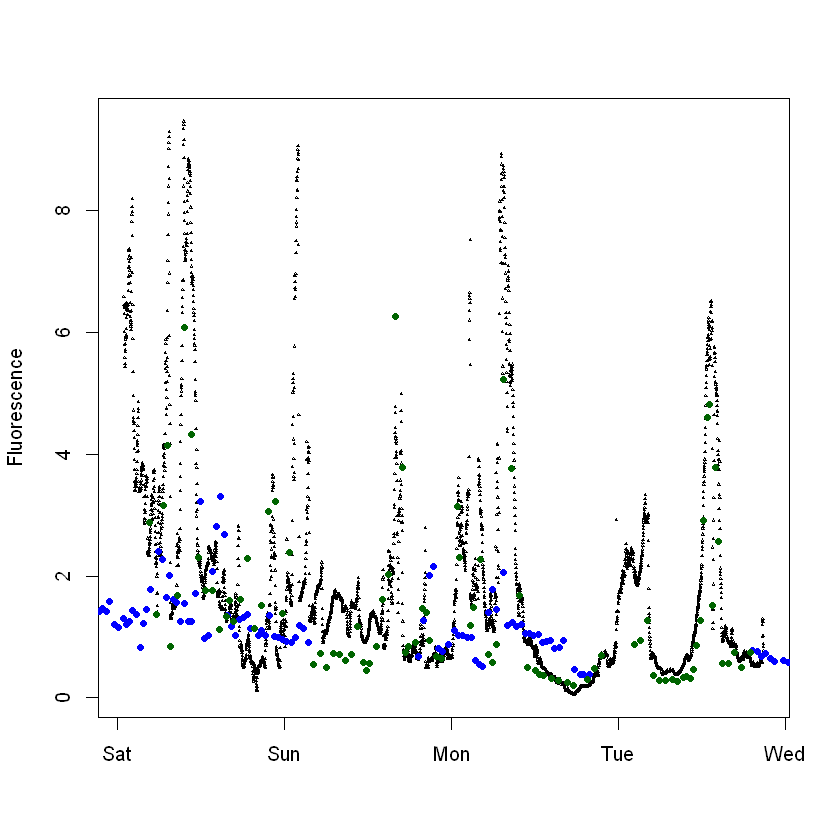

In [302]:
l = which(ship.data$Cycle == 'SeaSoar1')
plot(ship.data$DT[l], ship.data$FL[l], pch=2, cex=0.2, ylab='Fluorescence', xlab='')
points(chl$Date, chl$Chl/10, pch=16, cex=0.8, col='blue')
points(real$Datetime.GMT, real$'Chlorophyll.a.(ugL)', pch=16, col='dark green', cex=0.8)

In [36]:
chl$ship = 0
for (i in 1:nrow(chl)) {
    chl$ship[i] = median(ship.data$FL[which(as.numeric(difftime(chl$Date[i], ship.data$DT, units = 'mins'))^2 < 15^2)], na.rm = TRUE)
}


Call:
lm(formula = ship ~ X.Chl. + 0, data = chl)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.2939  -0.6554   0.1380   2.6641  12.7499 

Coefficients:
       Estimate Std. Error t value Pr(>|t|)    
X.Chl. 0.097390   0.003933   24.76   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.262 on 916 degrees of freedom
  (12 observations deleted due to missingness)
Multiple R-squared:  0.4009,	Adjusted R-squared:  0.4003 
F-statistic: 613.1 on 1 and 916 DF,  p-value: < 2.2e-16


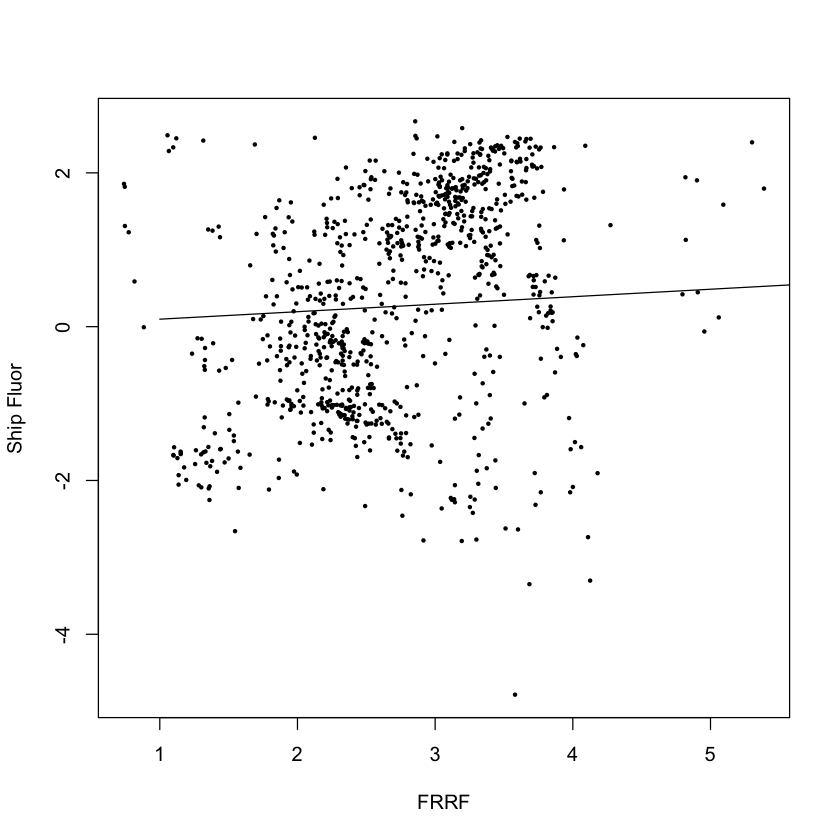

In [38]:
#plot(ship.data$DT, ship.data$FL, pch=20, cex=0.1, ylim=c(0,100), yaxs='i')
#points(chl$Date, chl$X.Chl., pch=15, col='dark green', cex=0.3)
plot(log(chl$X.Chl.), log(chl$ship), pch=16, cex=0.5, ylab='Ship Fluor', xlab='FRRF')

lm.chl = lm(ship ~ X.Chl. + 0, data = chl)
lines(c(1:100), predict(lm.chl, newdata = data.frame(X.Chl. = c(1:100))))

summary(lm.chl)